<a href="https://colab.research.google.com/github/Garmin90/FinanceDatabase/blob/main/ETF_interattivo_semplificato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import time
import pandas as pd
from pandas_datareader import data as pdr
import pandas_datareader.data as web
import yfinance as yfin

# 1. Importa dati da Yahoo Finance

In [ ]:
def import_data(name, start='2000-01-01'):
    """
    Questa funzione serve per importare i prezzi di un titolo da Yahoo finance.
    Restituisce in output un DataFrame.
    """

    end = dt.datetime.now()
    yfin.pdr_override()
    df = pdr.get_data_yahoo(name, start=start, end=end)
    df.reset_index(inplace=True)
    df.set_index("Date", inplace=True)
    df = df.drop(['Low', 'Open', 'Adj Close', 'High', 'Volume'], axis='columns')
    df.columns = [str(name)]
    return df


def generate_df_from_list(list_etf, column_names, starting_time = '2012-01-01'):
  """
  Questa funzione serve per importare i prezzi di più titoli da Yahoo finance.
  Restituisce in output un DataFrame.
  """

  for i in range(len(list_etf)):
    if i == 0:
      df = import_data(list_etf[i], start=starting_time)
    else:
      new_df = import_data(list_etf[i], start=starting_time)
      df = df.join(new_df, on=df.index)

  df.fillna(inplace=True, method='ffill')
  df.columns = column_names

  df = df[df.index >= starting_time]

  return df

### Non hedged DataFrame
Importa dati relativi ad ETF con cambio aperto (azionario e oro)

In [ ]:
trading_days_per_year = 252

df = generate_df_from_list(['SWDA.MI', 'XGLE.MI', 'XAD5.MI'],
                           column_names = ['azionario $', 'obbligazionari EU €', 'oro $'],
                           starting_time = '2012-01-01')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


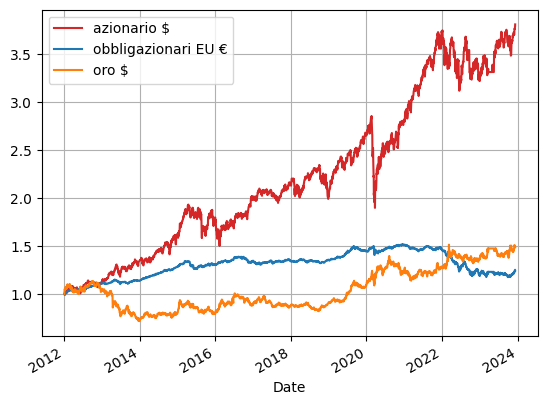

In [ ]:
(df/df.iloc[0, :]).plot(color=['C3', 'C0', 'C1'])
plt.grid()
plt.show()

### Hedged DataFrame
Importa dati relativi ad ETF con cambio coperto

In [ ]:
df_hedged = generate_df_from_list(['IWDE.MI', 'XGLE.MI', 'XAD1.MI'],
                                   column_names = ['azionario €', 'obbligazionario EU €', 'oro €'],
                                   starting_time = '2012-01-01')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


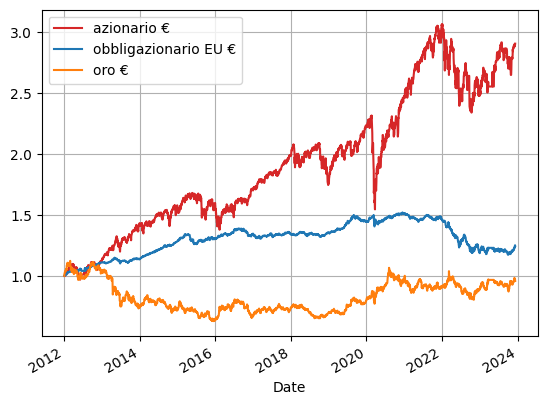

In [ ]:
(df_hedged/df_hedged.iloc[0, :]).plot(color=['C3', 'C0', 'C1'])
plt.grid()
plt.show()

# 2. Definisci funzioni per simulare l'evoluzione del portafoglio

In [ ]:
def simula_andamento(df,
                     pesi,
                     nomi_colonne,
                     trading_days_per_year=252,
                     ribilanciamento=True):
  """
  Questa funzione simula l'andamento di un investimento, al lordo della tassazione.
  Prende in input:
  - df: il DataFrame con i prezzi dei titoli
  - pesi: i pesi di azionario, obbligazionario e oro
  - nomi_colonne: i nomi delle colonne da assegnare al DataFrame

  Resistuisce in output un DataFrame con i prezzi dei titoli, l'andamento dell'investimento e del capitale non investito
  """

  assert np.sum(np.array(pesi)) == 100, "La somma dei pesi deve essere uguale a 100"
  assert len(pesi) == len(nomi_colonne), "La lunghezza del vettore 'pesi' deve essere uguale alla lunghezza del vettore 'nomi colonne'"

  inv_iniziale = 100
  n_titoli = inv_iniziale*(np.array(pesi)/100)/np.array(df.iloc[0, :])
  capitale_versato = []

  # aggiorna andamento
  new_matrix = np.zeros([len(df), len(pesi)])

  for i in range(len(df)):
    capitale_versato.append(inv_iniziale)

    for j in range(len(pesi)):
      new_matrix[i, j] = n_titoli[j]*df.iloc[i, j]

    # ribilanciamento
    if (i%trading_days_per_year==0) and (i>0):
      parziale = np.sum(new_matrix[i, :])
      # aggiorna numero titoli, ribilanciando il portafoglio
      if ribilanciamento:
        n_titoli = (parziale*np.array(pesi)/100)/np.array(df.iloc[i, :])

  totale = np.sum(new_matrix, axis=1)

  df_results = pd.DataFrame(new_matrix,
                            columns=nomi_colonne,
                            index=df.index)
  df_results['totale'] = totale
  df_results['capitale_versato'] = capitale_versato

  return df_results

In [ ]:
df_results = simula_andamento(df,
                              pesi = [60, 40, 0],
                              nomi_colonne=['azionario', 'obbligazionario', 'oro'],
                              ribilanciamento=True)

df_results

,azionario,obbligazionario,oro,totale,capitale_versato
Date,,,,,
2012-01-02,60.000000,40.000000,0.0,100.000000,100
2012-01-03,60.000000,40.016376,0.0,100.016376,100
2012-01-04,59.490811,40.016376,0.0,99.507187,100
2012-01-05,59.490811,39.766027,0.0,99.256838,100
2012-01-06,59.490811,39.766027,0.0,99.256838,100
...,...,...,...,...,...
2023-12-04,147.552259,98.513026,0.0,246.065284,100
2023-12-05,148.292150,99.357289,0.0,247.649439,100
2023-12-06,148.495621,99.613834,0.0,248.109455,100


# 3. Definisci funzioni per interattività

In [ ]:
def show_portfolio_evolution(azionario, oro_10percento=True, ribilanciamento_annuale=True, copertura_valutaria=False):
  """
  Questa funzione mostra graficamente l'andamento dell'investimento al variare della quota azionaria,
  della quota di oro.
  Si possono anche attivare e disattivare le opzioni di ribilanciamento e di copertura valutaria.
  """

  if copertura_valutaria:
    data = df_hedged
    nomi_colonne = ['azionario globale € hedged', 'obbligazionario EU €', 'oro € hedged']
  else:
    data = df
    nomi_colonne = ['azionario globale $', 'obbligazionario EU €', 'oro $']

  if oro_10percento == True:
    oro = 10
  else:
    oro = 0

  pesi = [azionario, 100-azionario-oro, oro]

  #print('Composizione del portafoglio', pesi)
  df_results = simula_andamento(data,
                                pesi = pesi,
                                nomi_colonne = nomi_colonne,
                                ribilanciamento=ribilanciamento_annuale)

  df_results['totale'].plot(figsize=(8, 5), color='C2')
  plt.title("Evoluzione dell'investimento")
  plt.ylabel('Rendimento lordo totale')
  plt.ylim(50, 400)
  plt.yticks(np.arange(50, 410, 50), ['-50%', '0%', '50%', '100%', '150%', '200%', '250%', '300%'])
  plt.grid()
  plt.legend()

  plt.tight_layout()

  #plt.savefig('simulazione.png', dpi=300)
  plt.show()

In [ ]:
plt.style.use('seaborn-dark')

#3rd party widgest need to be enabled during a session
from google.colab import output
output.enable_custom_widget_manager()

# widget modules
from ipywidgets import interact, interactive
import ipywidgets as widgets

interactive_plot = interactive(show_portfolio_evolution,
                               azionario=widgets.IntSlider(min=0, max=90, step=5, value=50))

interactive_plot

<ipython-input-10-2ccb8fe31194>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


interactive(children=(IntSlider(value=50, description='azionario', max=90, step=5), Checkbox(value=True, descr…